In [2]:
import pandas as pd
import numpy as np
import datetime as DT
from geopy import Nominatim
import geocoder
import geopy.distance
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = '/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1003/share/proj'
from mpl_toolkits.basemap import Basemap

En primer lugar se accede a un listado de clientes potenciales con intensiones de realizar una compra, cada uno de ellos debe Georreferenciarse a través de la dirección o la localidad que han consignado. 

In [21]:
#GEORREFERENCIAR EL LISTADO DE CLIENTES POTENCIALES

clientes = pd.read_excel('clientes finales simulación (flip enero).xlsx').fillna('')

#Se corrigen algunos términos erroneos en la denominación de las localidades
clientes['Localidad'] = clientes['Localidad'].str.replace(' COOP', '') 

#se crea dos nuevas string dentro del dataframe, una "dirección" y otra "ciudad"
clientes['Dirección'] = clientes['Calle/num'] + ', ' + clientes['Localidad'] + ', ' + clientes['Barrio'] + ', ' + clientes['Provincia']+ ', Argentina'
clientes['Ciudad'] = clientes['Localidad'] + ', ' + clientes['Provincia'] + ', Argentina'

#Se crean dos listas con las columnas antes creadas
direcciones_clientes= clientes['Dirección'].tolist()
ciudades_clientes= clientes['Ciudad'].tolist()

#Se crean listas vacías para almacenar latitudes y longitudes
latitudes =[]
longitudes = []

#se recurre a la librería geopy para recolectar coordenadas de los clientes
geolocator = Nominatim(user_agent="xxxxxxxx.com.ar/")

#se buscan dos coordenadas, la de la dirección y la de la ciudad del cliente
for line in range(len(direcciones_clientes)):
    location_d = geolocator.geocode(direcciones_clientes[line], timeout=100)
    location_c = geolocator.geocode(ciudades_clientes[line], timeout=100)
    
#se genera un if por el cual si no se encontraron coordenadas para la dirección se asignan las de la ciudad,
#si tampoco se encontró para la ciudad, se asigna 0
#si se encontraron coordenadas de la dirección, pero la distancia entre estas y las de la ciudad es muy grande
#se asume que hay un error en las primeras y se consignan las de la ciudad

    if location_d is None:
        if location_c is None:
            latitudes.append(0)
            longitudes.append(0)
        else:
            latitudes.append(location_c.latitude)
            longitudes.append(location_c.longitude)
    else:
        #calculo distancia entre coor domicilio y coor ciudad
        coords_1 = (location_d.latitude, location_d.longitude)
        coords_2 = (location_c.latitude, location_c.longitude)
        distance_d_c = geopy.distance.geodesic(coords_1, coords_2).km    
           
        if distance_d_c < 10:
            latitudes.append(location_d.latitude)
            longitudes.append(location_d.longitude)
        else:
            latitudes.append(location_c.latitude)
            longitudes.append(location_c.longitude)


#Se genera un dataframe con las nuevas localidades encontradas, se eliminan aquellos que no encontró
direcciones_clientes_coor = pd.DataFrame({'Dirección':direcciones_clientes, 'latitud': latitudes, 'longitud': longitudes})  
direcciones_clientes_coor['latitud'] = direcciones_clientes_coor['latitud'].fillna(0)
direcciones_clientes_coor = direcciones_clientes_coor[direcciones_clientes_coor['latitud'] != 0]

#se cruzan las coordenadas con el dataframe de clientes
clientes = pd.merge (clientes, direcciones_clientes_coor, on= 'Dirección', how= 'left')

Ahora se recurre a un conjunto de datos internos de distribuidores y sus clientes actuales, se usaran las coordenadas de dichos clientes actuales para asignar los clientes potenciales georreferenciados

In [24]:
#ABRIR DATOS INTERNOS CON DETALLES DE CLIENTES ACTUALES POR DISTRIBUIDOR
datos = pd.read_excel('Carga por Categoría.xlsx')

#Realizar correcciones en el reporte
new_header2 = datos.iloc[6] 
datos= datos[7:] 
datos.columns = new_header2 

datos['Provincia'] = datos['Provincia'].replace('BENI', '0')
datos['Provincia'] = datos['Provincia'].fillna('0')
datos['Ciudad'] = datos['Ciudad'].fillna('0')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. LA PAMPA)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. JUJUY)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. CORDOBA)','')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. RIO NEGRO)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. TIERRA DEL FUEGO)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. TUCUMAN)','')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. MISIONES)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. SALTA)',  '')
datos['Ciudad'] = datos['Ciudad'].str.replace('(PROV. CORRIENTES)', '')
datos['Ciudad'] = datos['Ciudad'].str.replace('()', '')
datos['Ciudad'] = datos['Ciudad'].str.replace(' COOP', '')  
datos['Ciudad'] = datos['Ciudad'].str.replace('CAPITAL FEDERAL Y ALREDEDORES', 'CABA') 

#control de cantidad de datos
print (datos.Provincia[datos["Ciudad"]=='0'].count())
print (datos.Provincia[datos["Provincia"]=='0'].count())

1450
1450


In [25]:
# USAR ARCHIVO COMPLEMENTARIO DE LAT Y LON (para ganar tiempo de búsqueda)

lat_long = pd.read_excel(r'lat y long por localidad argentina.xlsx')

lat_long = lat_long.rename(columns={"localprov": "ciudad", ' Lon': 'longitud', 'Lat': 'latitud'})
lat_long = lat_long[['ciudad', 'latitud', 'longitud']]

In [26]:
#se hace el primer cruce de los clientes ya existentes con las ciudades que ya estaban georreferenciadas
datos['ciudad'] = datos['Ciudad'] + ", " + datos['Provincia'] + ', Argentina'
datos= pd.merge(datos, lat_long, on='ciudad', how='left').fillna(0)

In [27]:
#se buscan missings y se genera una lista con las ciudades faltantes
datos_lat_lon_miss = datos[['ciudad', 'latitud', 'longitud']]
datos_lat_lon_miss = datos_lat_lon_miss.loc[datos_lat_lon_miss['latitud'] == 0]
datos_lat_lon_miss = datos_lat_lon_miss.loc[datos_lat_lon_miss['ciudad'] != '0, 0, Argentina']
ciudades_sinLatLon = datos_lat_lon_miss['ciudad'].unique()
ciudades_sinLatLon_list = datos_lat_lon_miss['ciudad'].unique().tolist()

print (ciudades_sinLatLon_list)

['SAN AGUSTIN DEL VALLE FERTIL, SAN JUAN, Argentina', 'SAN ANTONIO DE OBLIGADO, SANTA FE, Argentina', 'SAN MARTIN DE LAS ESCOBAS, SANTA FE, Argentina', 'LOS BRITOS - DTO TIMBO NUEVO, TUCUMAN, Argentina']


In [28]:
#se buscan la lat y lon de las ciudades que faltan y se agregan al dataframe original de lat y lon

latitudes =[]
longitudes = []

geolocator = Nominatim(user_agent="xxxxxx.com.ar/")

for line in ciudades_sinLatLon_list:
    location = geolocator.geocode(line, timeout=100)
    if location is None:
        latitudes.append(0)
        longitudes.append(0)
    else:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)

#se genera un dataframe con las nuevas localidades encontradas, se eliminan aquellas que no encontró
ciudades_sinLatLon_coor = pd.DataFrame({'ciudad':ciudades_sinLatLon_list, 'latitud': latitudes, 'longitud': longitudes})  
ciudades_sinLatLon_coor = ciudades_sinLatLon_coor[ciudades_sinLatLon_coor['latitud'] != 0]

#se une esta información al dataframe original de lat y long
frames_LatLon = [lat_long, ciudades_sinLatLon_coor]
lat_lon_nuevo = pd.concat(frames_LatLon, sort=False)

#se guarda el nuevo dataframe para próximos usos
lat_lon_nuevo.to_excel(r'lat y long por localidad argentina.xlsx', index=False)

In [29]:
#se eliminan las lat y long anteriores del dataframe y se vuelve a cruzar

datos = datos.drop(['latitud', 'longitud'], axis=1)
datos= pd.merge(datos, lat_lon_nuevo, on='ciudad', how='left').fillna(0)

In [30]:
#puede darse el caso de que existan clientes actuales sin carga de localidades
#se utilizan las de los distribuidores para no perder información

#Primero se recurre a un archivo que almacena las localidades de los distribuidores y sus coordenadas
localidades_AC = pd.read_excel(r'localidades por AC.xlsx')

#Se realizan correcciones
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. LA PAMPA)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. JUJUY)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. CORDOBA)','')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. RIO NEGRO)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. TIERRA DEL FUEGO)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. TUCUMAN)','')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. MISIONES)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. SALTA)',  '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('(PROV. CORRIENTES)', '')
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace(' COOP', '') 
localidades_AC['Localidad'] = localidades_AC['Localidad'].str.replace('CAPITAL FEDERAL Y ALREDEDORES', 'CABA') 

#se genera la string "ciudad"
localidades_AC['ciudad'] = localidades_AC['Localidad'] + ", " + localidades_AC['Provincia'] + ', Argentina'

#se buscan lat y lon de las ciudades de los AC que podrían faltar
geolocator = Nominatim(user_agent="https://empirical.com.ar/")

for line in range (len(localidades_AC)):
    if localidades_AC['latitud'][line] == 0:
        location = geolocator.geocode(localidades_AC['ciudad'][line], timeout=100)
        if location is None:
            localidades_AC['latitud'][line] ==0
            localidades_AC['longitud'][line] ==0
        else:
            localidades_AC['latitud'][line] = localidades_AC['latitud'][line] + location.latitude
            localidades_AC['longitud'][line] = localidades_AC['longitud'][line] + location.longitude

#se guarda de nuevo el listado
localidades_AC.to_excel(r'localidades por AC.xlsx', index=False)

In [31]:
#Cambio de header
localidades_AC = localidades_AC.rename(columns={"latitud": "latitud_AC", 'longitud': 'longitud_AC'})

#Se reemplazan valores perdidos de lat y lon por las de los dis
datos= pd.merge(datos, localidades_AC, on='Id AC Sup.', how='left').fillna(0)

#imputar lat de los distribuidores en aquellos clientes que tienen valores erroneos
datos.loc[datos['latitud'] > -21, 'latitud'] = datos['latitud_AC']
datos.loc[datos['latitud'] < -56, 'latitud'] = datos['latitud_AC']

#imputar Lon de los distribuidores en aquellos clientes que tienen valores erroneos
datos.loc[datos['longitud'] > -52, 'longitud'] = datos['longitud_AC']
datos.loc[datos['longitud'] < -74, 'longitud'] = datos['longitud_AC']

In [32]:
#ESTIMAR LAS MEDIANAS DE LAS REDES DE CLIENTES DE LOS DISTRIBUIDORES
#PARA TENER UN CENTROIDE DE OPERACIÓN DE CADA UNO

lat_lon_CPs_AC = datos[['Id AC Sup.', 'latitud', 'longitud']]

lat_lon_median_AC= pd.pivot_table(lat_lon_CPs_AC, values=['latitud', 'longitud'], 
                                  index=['Id AC Sup.'], 
                                  aggfunc='median').fillna(0)

lat_lon_median_AC = lat_lon_median_AC.reset_index()
lat_lon_median_AC.columns = ['Id AC Sup.', 'latitud_mediana', 'longitud_mediana']

In [33]:
#comparación de centroides de dos distribuidores
datos_un_AC = datos[datos['Id AC Sup.'] == 912]
mediana_un_AC = lat_lon_median_AC[lat_lon_median_AC['Id AC Sup.'] == 912]

datos_un_AC_2 = datos[datos['Id AC Sup.'] == 1830]
mediana_un_AC_2 = lat_lon_median_AC[lat_lon_median_AC['Id AC Sup.'] == 1830]

Se grafican las redes de clientes actuales de dos distribuidores y los centroides de cada una de ellas

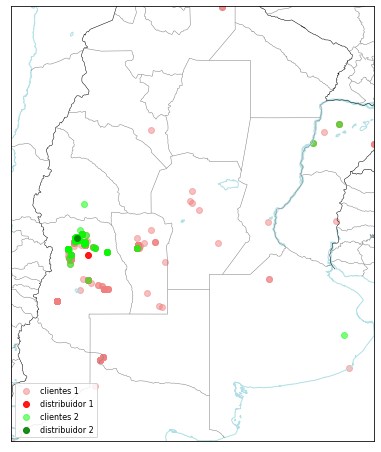

In [119]:
#se generan 4 grupos de cordenadas para los dos distribuidores y para los clientes actuales de cada uno
lats_C = datos_un_AC['latitud'].values
lons_C = datos_un_AC['longitud'].values

lats_A = mediana_un_AC['latitud_mediana'].values
lons_A = mediana_un_AC['longitud_mediana'].values

lats_C2 = datos_un_AC_2['latitud'].values
lons_C2 = datos_un_AC_2['longitud'].values

lats_A2 = mediana_un_AC_2['latitud_mediana'].values
lons_A2 = mediana_un_AC_2['longitud_mediana'].values

#se establecen latitudes mínimas y máximas
lats = np.concatenate((lats_C, lats_A))
lons = np.concatenate((lons_C, lons_A))

min_lon = lons.min()-0.02
min_lat = lats.min()-0.02
max_lon = lons.max()+0.02
max_lat = lats.max()+0.02

#se definen las características del mapa
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h', 
            llcrnrlon= min_lon, 
            llcrnrlat = min_lat, 
            urcrnrlon = max_lon, 
            urcrnrlat=max_lat)
            
m.drawcoastlines(color='powderblue')
m.drawcountries(color='black')
m.drawstates(color='grey')

# se grafican las coordenadas medianas de los distribuidores y las de los clientes actuales de cada uno
c1 = m.scatter(lons_C, lats_C, latlon=True, color = 'lightcoral', alpha=0.5) #agentes
a1 = m.scatter(lons_A, lats_A, latlon=True, color = 'r', alpha=0.9) #clientes
c2 = m.scatter(lons_C2, lats_C2, latlon=True, color = 'lime', alpha=0.5) #agentes
a2 = m.scatter(lons_A2, lats_A2, latlon=True, color = 'g', alpha=0.9) #clientes

#se definen las leyendas
plt.legend((c1,a1,c2,a2),
           ('clientes 1', 'distribuidor 1', 'clientes 2', 'distribuidor 2'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=8)

A continuación se estiman las distancias entre clientes potenciales que dejaron sus datos y los centroides de las redes de los distribuidores

In [37]:
clientes = clientes.fillna(0)

In [73]:
#DISTANCIAS ENTRE CLIENTE POTENCIALES Y MEDIANAS DE LAS REDES DE CADA DISTRIBUIDOR
#CRITERIO: Se asigno cada cliente potencial a los tres distribuidores más cercanos,
#ordenando a los tres según la PROPORCIÓN DE VENTAS DEL MES. 

AC_asig_dict = []

#CALCULOS DE UNIDEDADES VENDIDAS DEL MES POR DISTRIBUIDOR
unidades_AC= pd.pivot_table(datos, values=['Cant. Tot. Excep. No Comis.'], 
                            index=['Id AC Sup.'], 
                            aggfunc='sum').fillna(0)

total = unidades_AC['Cant. Tot. Excep. No Comis.'].sum()
unidades_AC['participación_mes'] = unidades_AC['Cant. Tot. Excep. No Comis.']/total

#PARA CADA CLIENTE SE BUSCA A LOS 3 DISTRIBUIDORES MÁS CERCANOS 
for j in range (len(clientes)):
    distancias = []

    for i in lat_lon_median_AC.index:
        coords_1 = (lat_lon_median_AC['latitud_mediana'][i], lat_lon_median_AC['longitud_mediana'][i])
        coords_2 = (clientes['latitud'][j], clientes['longitud'][j])
    
        distance = geopy.distance.geodesic(coords_1, coords_2).km
    
        distancias.append(distance)
    
    lat_lon_median_AC['dist'] = distancias

#SACAR EL TOP 3 DE DISTRIBUIDORES MÁS CERCANOS Y ORDENAR POR VENTAS DEL MES
    lat_lon_median_AC_ord = lat_lon_median_AC.sort_values(by='dist')
    lat_lon_median_AC_ord_top_3 = lat_lon_median_AC_ord.iloc[:3,:1]

    unidades_top_3 = pd.merge(lat_lon_median_AC_ord_top_3, unidades_AC, on='Id AC Sup.', how='left').fillna(0)

    unidades_top_3 = unidades_top_3.sort_values(by = 'participación_mes', ascending = False)
    
    unidades_top_3 = unidades_top_3.reset_index()
    
    dist_asignado = unidades_top_3['Id AC Sup.'].iloc[:1].values[0]
    
    AC_asig_dict.append(dist_asignado)

In [82]:
#unir distribuidores asignados con la tabla de clientes potenciales
clientes['dist_asig'] = AC_asig_dict

Prueba de resultados

In [95]:
#comparar clientes potenciales asignados de dos distribuidores
dist_1 = 912
dist_2 = 1830

CPs_asignados_AC = clientes[clientes['dist_asig'] == dist_1]
CPs_asignados_AC_2 = clientes[clientes['dist_asig'] == dist_2]

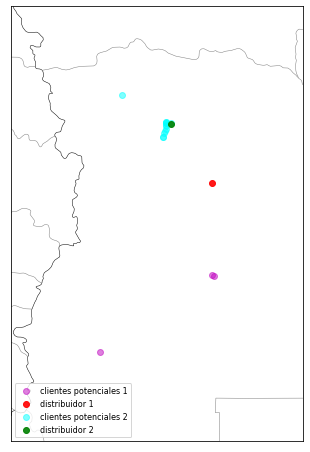

In [120]:
#se generan 4 grupos de cordenadas para los dos distribuidores y para los clientes asignados a cada uno

lats_C = CPs_asignados_AC['latitud']
lons_C = CPs_asignados_AC['longitud']

lats_A = mediana_un_AC['latitud_mediana']
lons_A = mediana_un_AC['longitud_mediana']

lats_C2 = CPs_asignados_AC_2['latitud']
lons_C2 = CPs_asignados_AC_2['longitud']

lats_A2 = mediana_un_AC_2['latitud_mediana']
lons_A2 = mediana_un_AC_2['longitud_mediana']

#se establecen latitudes mínimas y máximas
lats = np.concatenate((lats_C, lats_A, lats_C2, lats_A2))
lons = np.concatenate((lons_C, lons_A, lons_C2, lons_A2))

min_lon = lons.min()-1
min_lat = lats.min()-1
max_lon = lons.max()+1
max_lat = lats.max()+1

#se definen las características del mapa
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h', 
            llcrnrlon= min_lon, 
            llcrnrlat = min_lat, 
            urcrnrlon = max_lon, 
            urcrnrlat=max_lat)
            
#m.drawcoastlines(color='powderblue')
m.drawcountries(color='black')
m.drawstates(color='grey')

# se grafican las coordenadas medianas de los distribuidores y las de los clientes potenciales asignados
c1 = m.scatter(lons_C, lats_C, latlon=True, color = 'm', alpha=0.5) #clientes potenciales 1
a1 = m.scatter(lons_A, lats_A, latlon=True, color = 'r', alpha=0.9) #distribuidor 1
c2 = m.scatter(lons_C2, lats_C2, latlon=True, color = 'cyan', alpha=0.5) #clientes potenciales 2
a2 = m.scatter(lons_A2, lats_A2, latlon=True, color = 'g', alpha=0.9) #distribuidor 2

#se definen las leyendas
plt.legend((c1,a1,c2,a2),
           ('clientes potenciales 1', 'distribuidor 1', 'clientes potenciales 2', 'distribuidor 2'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=8)